In [ ]:
import sys
from pathlib import Path

# add package path to sys.path, skip if package is installed
# module_path = Path.cwd().parent
# sys.path.append(str(module_path))

from tqdm import tqdm

import matplotlib.pyplot as plt

import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models
import pytorch_lightning as pl

from sklearn.metrics import classification_report, accuracy_score
from targeted_fgsm.fgsm import TargetedFGSM


In [ ]:
class ResNetMNIST(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    # define model and loss
    self.model = models.resnet18(num_classes=10)  # mnist classes
    self.model.conv1 = nn.Conv2d(1, 64, 
                                 kernel_size=(7, 7), 
                                 stride=(2, 2), 
                                 padding=(3, 3), 
                                 bias=False)  # adapt resnet18's first layer for 1 channel greyscale images
    self.loss = nn.CrossEntropyLoss()

  def forward(self, x):
    return self.model(x)
  
  def training_step(self, batch, batch_no):
    # single training step
    x, y = batch
    logits = self(x)
    loss = self.loss(logits, y)
    return loss
  
  def configure_optimizers(self):
    return torch.optim.RMSprop(self.parameters(), lr=0.005)


In [ ]:
class ResNetMNIST_ft(pl.LightningModule):
  
  def __init__(self):
    super().__init__()

    self.model = models.resnet18(pretrained=True)
    self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    for param in self.model.parameters():
        param.requires_grad = False

    self.model.fc = torch.nn.Linear(self.model.fc.in_features, 10)
    for param in self.model.fc.parameters():
        param.requires_grad = True

    self.loss = nn.CrossEntropyLoss()

  def forward(self, x):
    return self.model(x)
  
  def training_step(self, batch, batch_no):

    x, y = batch
    logits = self(x)
    loss = self.loss(logits, y)
    return loss
  
  def configure_optimizers(self):
    return torch.optim.RMSprop(self.parameters(), lr=0.01)


In [158]:
def get_prediction(x, model: pl.LightningModule):

  model.freeze() # prepares model for predicting

  probabilities = torch.softmax(model(x), dim=1)
  predicted_class = torch.argmax(probabilities, dim=1)
  
  return predicted_class, probabilities

In [197]:
def plt_img(img, adv_img, y_true, y_pred, y_adv, y_target):

    plt.subplot(1, 2, 1)
    plt.imshow(img.detach().numpy())
    plt.title(f"Original (true: {y_true} | pred: {y_pred})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(adv_img.detach().numpy())
    plt.title(f"Attacked (target: {y_target} | pred: {y_adv})")
    plt.axis("off")


In [138]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

data_trn = datasets.MNIST("mnist", train=True, download=True, transform=transform)
data_tst = datasets.MNIST("mnist", train=False, download=True, transform=transform)

trn_loader = torch.utils.data.DataLoader(data_trn, batch_size=64, shuffle=True)
tst_loader = torch.utils.data.DataLoader(data_tst, batch_size=64)

In [ ]:
# example 1
# I first experimented with ResNetMNIST, 
# which uses the architecture of ResNet18 & retrain the parameters
# the model converges fast and achieved a very high accuracy (0.98) on test images
# however, as mnist is a small and relatively simple dataset
# the model is very robust and only strong perturbation can correctly predict the target (wrong) labels

In [ ]:
# train ResNetMNIST
model = ResNetMNIST()
trainer = pl.Trainer(
    max_epochs=1,
)
trainer.fit(model, trn_loader)

trainer.save_checkpoint("resnet18_mnist.pt")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | ResNet           | 11.2 M | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 938/938 [00:12<00:00, 73.24it/s, v_num=10]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 938/938 [00:12<00:00, 72.68it/s, v_num=10]


In [ ]:
# inference on test set
inference_model = ResNetMNIST.load_from_checkpoint("resnet18_mnist.pt")
label_true, label_pred = [], []
for batch in tqdm(iter(tst_loader), total=len(tst_loader)):
  
  x, y = batch
  label_true.extend(y)

  preds, probs = get_prediction(x, inference_model)
  label_pred.extend(preds.cpu())

100%|██████████| 157/157 [00:34<00:00,  4.56it/s]


In [161]:
# evaluate test performance
print(classification_report(label_true, label_pred, digits=3))
print(accuracy_score(label_true, label_pred))

              precision    recall  f1-score   support

           0      0.983     0.995     0.989       980
           1      0.990     0.994     0.992      1135
           2      0.973     0.994     0.983      1032
           3      0.979     0.993     0.986      1010
           4      0.985     0.992     0.988       982
           5      0.980     0.979     0.979       892
           6      0.989     0.981     0.985       958
           7      0.968     0.980     0.974      1028
           8      0.995     0.952     0.973       974
           9      0.979     0.958     0.968      1009

    accuracy                          0.982     10000
   macro avg      0.982     0.982     0.982     10000
weighted avg      0.982     0.982     0.982     10000

0.982


In [ ]:
# targeted adversarial attacks with iterative FGSM / PGD
attacker = TargetedFGSM(epsilon=1, alpha=0.01, max_iter=100)

adv_images, label_adv, label_true, label_target, label_pred = [], [], [], [], []
for i in tqdm(range(len(data_tst))):

    img, y_true = data_tst[i]
    img = img.unsqueeze(0).to('cpu')
    y_target = (y_true + 1) % 10   # use the next digit as the target label

    adv_img = attacker.add_noise(img, y_target, inference_model)
    adv_images.append(adv_img.detach().cpu())

    pred, _ = get_prediction(adv_img, inference_model)

    label_adv.append(pred.item())
    label_true.append(y_true)
    label_target.append(y_target)

    pred, _ = get_prediction(img, inference_model)
    label_pred.append(pred.item())

    if i == 100:  # test on the 1st 100 images to save time
        break

  1%|          | 100/10000 [01:10<1:56:50,  1.41it/s]


In [185]:
# check accuracy
# the perterbed images are "correctly" misclassified as the target classes
print(f"Accuracy: \n"
      f"Adversarial vs true: {accuracy_score(label_true, label_adv):.2f}\n"
      f"Adversarial vs target: {accuracy_score(label_target, label_adv):.2f}\n"
      f"Predicted vs true: {accuracy_score(label_true, label_pred):.2f}\n"
     )

Accuracy: 
Adversarial vs true: 0.01
Adversarial vs target: 0.99
Predicted vs true: 0.99



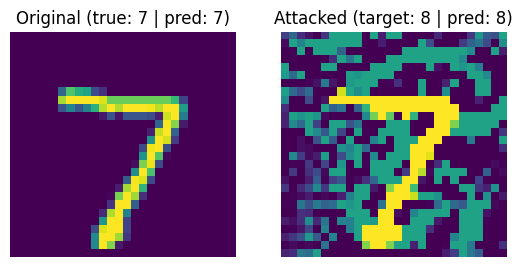

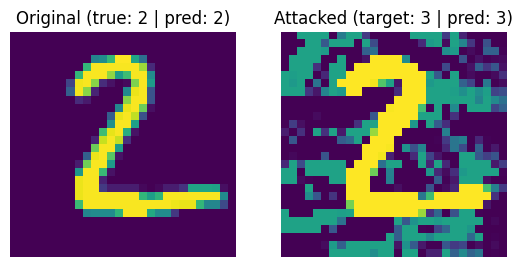

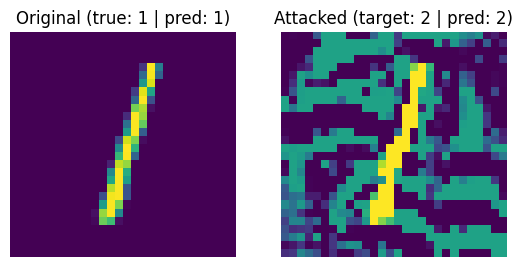

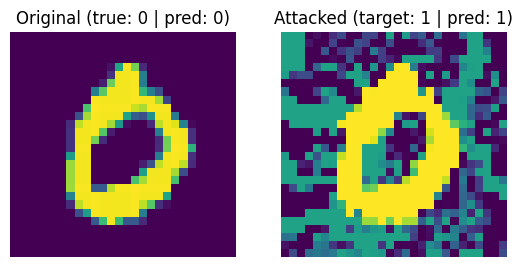

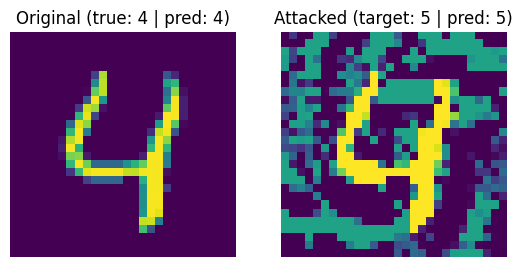

In [198]:
# plot the 1st 5 images
for i in range(5):
    plt.figure()
    plt_img(data_tst[i][0].squeeze(0), 
            adv_images[i].squeeze(0).squeeze(0),
            label_true[i],
            label_pred[i], 
            label_adv[i], 
            label_target[i])

In [ ]:
# example 2
# as mentioned earlier, ResNetMNIST is very robust on MNIST data
# potentially due to the robustness of ResNet architecture, and the low complexity of MNIST data
# this leads to a very high epsilon & pertubation to "trick" the model to "correctly" predict the target classes

# therefore, I decide to downgrade ResNetMNIST manually and see if it's easier to attack it
# in this example, I defined a new class, ResNetMNIST_ft, which freezes all parameters except for the ones on the final layer
# this greatly downgraded the performance with a low test accuracy
# but it becomes much easier to attack the model

In [ ]:
# train ResNetMNIST_ft (freeze the model except for the final layer)
model = ResNetMNIST_ft()
trainer = pl.Trainer(
    max_epochs=1,
)
trainer.fit(model, trn_loader)

trainer.save_checkpoint("resnet18_mnist_ft.pt")

In [199]:
# inference on test set
inference_model = ResNetMNIST.load_from_checkpoint("resnet18_mnist_ft.pt")
label_true, label_pred = [], []
for batch in tqdm(iter(tst_loader), total=len(tst_loader)):
  
  x, y = batch
  label_true.extend(y)

  preds, probs = get_prediction(x, inference_model)
  label_pred.extend(preds.cpu())

100%|██████████| 157/157 [00:36<00:00,  4.35it/s]


In [200]:
# evaluate test performance
print(classification_report(label_true, label_pred, digits=3))
print(accuracy_score(label_true, label_pred))

              precision    recall  f1-score   support

           0      0.710     0.205     0.318       980
           1      0.943     0.867     0.903      1135
           2      0.000     0.000     0.000      1032
           3      0.282     0.768     0.413      1010
           4      0.592     0.505     0.545       982
           5      0.414     0.302     0.349       892
           6      0.727     0.483     0.581       958
           7      0.729     0.449     0.556      1028
           8      0.287     0.527     0.371       974
           9      0.484     0.659     0.558      1009

    accuracy                          0.483     10000
   macro avg      0.517     0.477     0.459     10000
weighted avg      0.521     0.483     0.465     10000

0.4829


/Users/yuxinsun/miniforge3/envs/torch39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yuxinsun/miniforge3/envs/torch39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yuxinsun/miniforge3/envs/torch39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [ ]:
# targeted adversarial attacks with iterative FGSM / PGD
attacker = TargetedFGSM(epsilon=0.5, alpha=0.01, max_iter=100)

adv_images, label_adv, label_true, label_target, label_pred = [], [], [], [], []
for i in tqdm(range(len(data_tst))):

    img, y_true = data_tst[i]
    img = img.unsqueeze(0).to('cpu')
    y_target = (y_true + 1) % 10   # use the next digit as the target label

    adv_img = attacker.add_noise(img, y_target, inference_model)
    adv_images.append(adv_img.detach().cpu())

    pred, _ = get_prediction(adv_img, inference_model)

    label_adv.append(pred.item())
    label_true.append(y_true)
    label_target.append(y_target)

    pred, _ = get_prediction(img, inference_model)
    label_pred.append(pred.item())

    if i == 100:  # test on the 1st 100 images to save time
        break

  1%|          | 100/10000 [01:12<1:59:27,  1.38it/s]


In [229]:
# check accuracy
# the perterbed images are "correctly" misclassified as the target classes
print(f"Accuracy: \n"
      f"Adversarial vs true: {accuracy_score(label_true, label_adv):.2f}\n"
      f"Adversarial vs target: {accuracy_score(label_target, label_adv):.2f}\n"
      f"Predicted vs true: {accuracy_score(label_true, label_pred):.2f}\n"
     )

Accuracy: 
Adversarial vs true: 0.03
Adversarial vs target: 0.85
Predicted vs true: 0.46



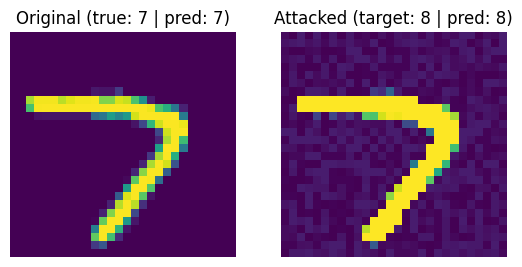

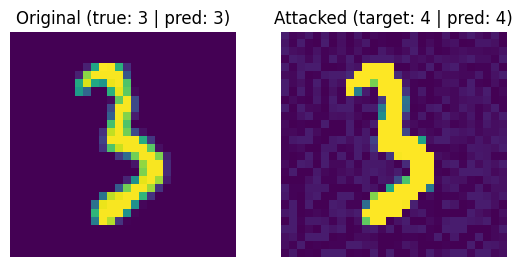

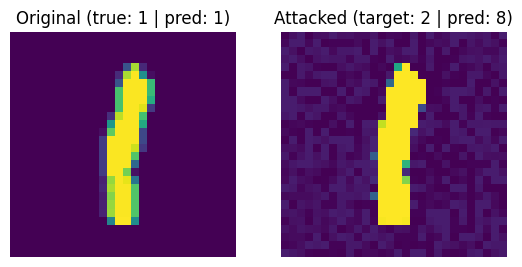

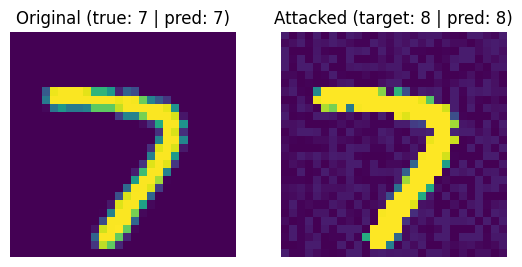

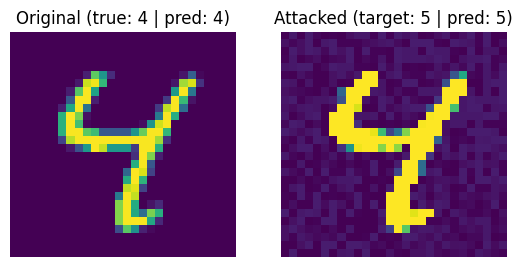

In [240]:
# for the correctly predicted images
# plot and check the adversarial attack performances

idx = np.where(np.asarray(label_true) == np.asarray(label_pred))[0]
idx = random.sample(idx.tolist(), 5)

for i in idx:
    plt.figure()
    plt_img(data_tst[i][0].squeeze(0), 
            adv_images[i].squeeze(0).squeeze(0),
            label_true[i],
            label_pred[i], 
            label_adv[i], 
            label_target[i])